Este notebook se emplea para crear las mascaras de CBIS_DDSM en formato PNG.
El resultado sera:
1- Carpeta con las imagenenes en formato png 
2- Carpeta con las mascaras en formato png

El numero de imagenes en ambas carpetas sera el mismo y el nombre de las imagenes sera el mismo en ambas carpetas.

In [36]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pydicom
from tqdm import tqdm

In [37]:
data_folder = pathlib.Path('/home/alalbiol/Data/mamo')
data_folder = pathlib.Path('/media/HD/mamo')

cbis_ddsm_path = data_folder / 'CBIS-DDSM'

In [38]:
calc_case_test = pd.read_csv( '../resources/cbis_ddsm/calc_case_description_test_set.csv')
calc_case_train = pd.read_csv( '../resources/cbis_ddsm/calc_case_description_train_set.csv')
mass_case_test = pd.read_csv( '../resources/cbis_ddsm/mass_case_description_test_set.csv')
mass_case_train = pd.read_csv( '../resources/cbis_ddsm/mass_case_description_train_set.csv')

calc_case_test['group'] = 'test'
calc_case_train['group'] = 'train'
mass_case_test['group'] = 'test'
mass_case_train['group'] = 'train'


all_case_train = pd.concat([calc_case_train, mass_case_train])
all_case_test = pd.concat([calc_case_test, mass_case_test])
all_case = pd.concat([all_case_train, all_case_test])

print(f'calc_case_test: {len(calc_case_test)}')
print(f'calc_case_train: {len(calc_case_train)}')
print(f'mass_case_test: {len(mass_case_test)}')
print(f'mass_case_train: {len(mass_case_train)}')
print(f'all_case_train: {len(all_case_train)}')
print(f'all_case_test: {len(all_case_test)}')
print(f'all_case: {len(all_case)} pero algunas son repetidas porque CBIS repite imagenes por lesiones')

all_case['good_image_path'] = None
all_case['good_mask_path'] = None


calc_case_test: 326
calc_case_train: 1546
mass_case_test: 378
mass_case_train: 1318
all_case_train: 2864
all_case_test: 704
all_case: 3568 pero algunas son repetidas porque CBIS repite imagenes por lesiones


In [41]:
#ahora el indice coincide con el row number
all_case.reset_index(drop=True, inplace=True)
all_case.tail()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,group,breast_density,mass shape,mass margins,good_image_path,good_mask_path
3563,P_01825,NaN,RIGHT,MLO,1,mass,NaN,NaN,3,BENIGN_WITHOUT_CALLBACK,3,Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Mass-Test_P_01825_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Mass-Test_P_01825_RIGHT_MLO_1/1.3.6.1.4.1.9590...,test,2.0,LOBULATED,MICROLOBULATED,None,None
3564,P_01833,NaN,RIGHT,MLO,1,mass,NaN,NaN,5,MALIGNANT,5,Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Mass-Test_P_01833_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Mass-Test_P_01833_RIGHT_MLO_1/1.3.6.1.4.1.9590...,test,2.0,IRREGULAR,ILL_DEFINED,None,None
3565,P_01865,NaN,LEFT,MLO,1,mass,NaN,NaN,4,MALIGNANT,2,Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_01865_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_01865_LEFT_MLO_1/1.3.6.1.4.1.9590....,test,2.0,IRREGULAR,ILL_DEFINED,None,None
3566,P_01912,NaN,RIGHT,CC,1,mass,NaN,NaN,5,MALIGNANT,4,Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_01912_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_01912_RIGHT_CC_1/1.3.6.1.4.1.9590....,test,3.0,IRREGULAR,SPICULATED,None,None
3567,P_01912,NaN,RIGHT,MLO,1,mass,NaN,NaN,5,MALIGNANT,4,Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Mass-Test_P_01912_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Mass-Test_P_01912_RIGHT_MLO_1/1.3.6.1.4.1.9590...,test,3.0,IRREGULAR,SPICULATED,None,None


In [33]:
def get_image_mask_path(case_row):
    image_path = case_row['image file path']
    
    
    # Sin empleamos png solo tenemos que cambiar la extenion
    image_path = image_path.replace('dcm','png').strip() #remove end of line
    image = Image.open(cbis_ddsm_path / image_path)

    # Si empleamos el dcm, hay que modificar el nombre, esta comprobado que da igual uno
    # u otro
    
    #image_path.replace('000000.dcm', '00000001.dcm'    
    #image = pydicom.dcmread(cbis_ddsm_path / ))
    #image = Image.fromarray(image.pixel_array)
     
    im_w = image.width
    im_h = image.height
    
    # Comprobamos por si acaso que la imagen sea imagen
    assert im_w > 1000 and im_h > 1000, f'Invalid image dimensions: {im_w}x{im_h}'
    assert np.array(image).dtype == np.int32, f'Invalid image dtype: {np.array(image).dtype}'
    assert np.array(image).max() > 500, f'Invalid image max value: {np.array(image).max()}'
    
    
    valid_masks = []
    
    # Los nombres de las mascaras son un lio, pero parece que por lo menos
    # el folder esta bien en casi todos los casos
    # El problema es que puede ser a veces png, dcm y hay otros png dcm en el folder
    
    # Primero probamos con los archivos dcm del tamaño correcto
    mask_path = case_row['ROI mask file path']    
    mask_path = cbis_ddsm_path / mask_path
    parent_folder = mask_path.parent
    dcm_masks = list(parent_folder.glob('*.dcm'))
    
    number_of_good_masks = 0
    for dcm_mask in dcm_masks:
        mask = pydicom.dcmread(dcm_mask)
        mask = Image.fromarray(mask.pixel_array) 
        # print(dcm_mask)
        # print(np.array(mask).dtype)
        # print(np.array(mask).max()) 
   
        mask_w = mask.width
        mask_h = mask.height
    
    #assert np.array(mask).dtype == np.uint8, f'Invalid mask dtype: {np.array(mask).dtype}'
    
        if  (mask_w == im_w and mask_h == im_h) and np.array(mask).dtype == np.uint8:
            number_of_good_masks += 1
            valid_masks.append(dcm_mask)

    # si encontramos mascara con el tamaño correcto salimos
    if number_of_good_masks == 1:
        return image_path, valid_masks[0] 
    elif number_of_good_masks > 1:
        print(f'More than one good mask found for {mask_path}')
        return None, None
            
    # No tenemos valid masks, 
    # como segunda opcion probamos dcm que tienen la misma relacion de aspecto
    
         
    for dcm_mask in dcm_masks:
        
        mask = pydicom.dcmread(dcm_mask)
        mask = Image.fromarray(mask.pixel_array)
        # print(dcm_mask)
        # print(np.array(mask).dtype)
        # print(np.array(mask).max()) 
        mask_w = mask.width
        mask_h = mask.height
        
        
        if  np.array(mask).dtype != np.uint8:
            continue  # que sea mascara!
        
        #print(mask_w/ mask_h / im_w * im_h)


        if mask_w/mask_h / im_w*im_h > 0.999 and mask_w/mask_h / im_w*im_h < 1.001:
            number_of_good_masks += 1
            valid_masks.append(dcm_mask)

    # de nuevo si encontramos una solo ya esta listo.
    if number_of_good_masks == 1:
        return image_path, valid_masks[0]     
    elif number_of_good_masks > 1:
        print(f'More than one good mask found for {mask_path}')
        return None, None
    
    
    # No tenemos valid masks,
    # probamos los png que tienen la misma relacion de aspecto o tamaño
    png_masks = list(parent_folder.glob('*.png'))
    #print(png_masks)

    for png_mask in png_masks:
        mask = Image.open(png_mask)
        mask_w = mask.width
        mask_h = mask.height
        
        # print(png_mask)
        # print(np.array(mask).dtype)
        # print(np.array(mask).max())
        
        if  np.array(mask).dtype != np.uint8:
            continue
        
        #print(mask_w/ mask_h / im_w * im_h)
        
        
        if  (mask_w == im_w and mask_h == im_h) and np.array(mask).dtype == np.uint8:
            number_of_good_masks += 1
            valid_masks.append(png_mask)
        elif mask_w/mask_h / im_w*im_h > 0.99 and mask_w/mask_h / im_w*im_h < 1.01:
            number_of_good_masks += 1
            valid_masks.append(png_mask)
            
    if number_of_good_masks == 1:
        return image_path, valid_masks[0]     
    elif number_of_good_masks > 1:
        print(f'More than one good mask found for {mask_path}')
        return None, None
    
    
    # ahroa solo queda esta Calc-Training_P_00474_LEFT_CC
    # aqui lo pongo a mano porque esta en carpetas diferentes a lo que 
    # pone aunque bajo el mismo paciente
    # He comprobado que ese paciente tiene solo una lesion asi que si encontramos
    # una mascara ya esta
    
    if "Calc-Training_P_00474_LEFT_CC" in str(image_path):
        image_path = cbis_ddsm_path/ 'Calc-Training_P_00474_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.114390037811229875730572783391891375397/1.3.6.1.4.1.9590.100.1.2.179094779913865355328314942890032167835/00000001.dcm'
        mask_path  = cbis_ddsm_path/ 'Calc-Training_P_00474_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.51237454713646035738565559272349757850/1.3.6.1.4.1.9590.100.1.2.282183550412854784817393110192237366418/00000002.dcm'
        
        return image_path, mask_path
    
    if "Calc-Training_P_00474_LEFT_MLO" in str(image_path):
        image_path = 'Calc-Training_P_00474_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.275365930412464771525793839621783178044/1.3.6.1.4.1.9590.100.1.2.416722881411737593414359448931127663526/00000001.dcm'
        mask_path = '/media/HD/mamo/CBIS-DDSM/Calc-Training_P_00474_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.317367128312662574506465519571363212715/1.3.6.1.4.1.9590.100.1.2.27611247910023474515584644283556391565/00000001.dcm'
    
        return image_path, mask_path
    
    return None, None
 

 


In [42]:
bad_nb =0
good_nb = 0
#processed_nb = 0

#all_case_kk = all_case.copy().iloc[:10]

total = len(all_case)

print(total)

for k in range(total):
    row = all_case.iloc[k]
    #print(row['image file path'])
    #print(row['ROI mask file path'])    
    image_path, mask_path = get_image_mask_path(row)
    #print(image_path, mask_path)
    if  image_path is None:
        bad_nb += 1
    else:
        good_nb += 1
        all_case.at[k,'good_image_path'] = image_path
        
        
        all_case.at[k,'good_mask_path'] = str(mask_path).replace('/media/HD/mamo/CBIS-DDSM/','')

    
    if len(all_case) > 3568:
        print("esta creciendo no se porque")
        break
    
    
    #processed_nb += 1
    
    # if processed_nb > 10:
    #     break
    
    
    print(f'{k} Good: {good_nb}, Bad: {bad_nb}')
    
print(all_case.iloc[:10])
    
    

3568
0 Good: 1, Bad: 0
1 Good: 2, Bad: 0
2 Good: 3, Bad: 0
3 Good: 4, Bad: 0
4 Good: 5, Bad: 0
5 Good: 6, Bad: 0
6 Good: 7, Bad: 0
7 Good: 8, Bad: 0
8 Good: 9, Bad: 0
9 Good: 10, Bad: 0
10 Good: 11, Bad: 0
11 Good: 12, Bad: 0
12 Good: 13, Bad: 0
13 Good: 14, Bad: 0
14 Good: 15, Bad: 0
15 Good: 16, Bad: 0
16 Good: 17, Bad: 0
17 Good: 18, Bad: 0
18 Good: 19, Bad: 0
19 Good: 20, Bad: 0
20 Good: 21, Bad: 0
21 Good: 22, Bad: 0
22 Good: 23, Bad: 0
23 Good: 24, Bad: 0
24 Good: 25, Bad: 0
25 Good: 26, Bad: 0
26 Good: 27, Bad: 0
27 Good: 28, Bad: 0
28 Good: 29, Bad: 0
29 Good: 30, Bad: 0
30 Good: 31, Bad: 0
31 Good: 32, Bad: 0
32 Good: 33, Bad: 0
33 Good: 34, Bad: 0
34 Good: 35, Bad: 0
35 Good: 36, Bad: 0
36 Good: 37, Bad: 0
37 Good: 38, Bad: 0
38 Good: 39, Bad: 0
39 Good: 40, Bad: 0
40 Good: 41, Bad: 0
41 Good: 42, Bad: 0
42 Good: 43, Bad: 0
43 Good: 44, Bad: 0
44 Good: 45, Bad: 0
45 Good: 46, Bad: 0
46 Good: 47, Bad: 0
47 Good: 48, Bad: 0
48 Good: 49, Bad: 0
49 Good: 50, Bad: 0
50 Good: 51, B

In [43]:
print(len(all_case))

3568


In [44]:
all_case.to_csv('../resources/cbis_ddsm/all_case_fixed.csv', index=False)



In [8]:
all_case = pd.read_csv('../resources/cbis_ddsm/all_case_fixed.csv')

In [46]:
all_case['id'] = all_case['patient_id'] + '_' + all_case['left or right breast'] + '_' + all_case['image view']

In [48]:
all_case.id

0        P_00005_RIGHT_CC
1       P_00005_RIGHT_MLO
2         P_00007_LEFT_CC
3        P_00007_LEFT_MLO
4         P_00008_LEFT_CC
              ...        
3563    P_01825_RIGHT_MLO
3564    P_01833_RIGHT_MLO
3565     P_01865_LEFT_MLO
3566     P_01912_RIGHT_CC
3567    P_01912_RIGHT_MLO
Name: id, Length: 3568, dtype: object

In [49]:
def calculate_bounding_box(mask, id, label):
    mask = np.array(mask)
    # Find non-zero (or region of interest) pixels
    rows, cols = np.where(mask > 0)
    
    if len(rows) == 0 or len(cols) == 0:
        # No region found
        return None

    # Calculate bounding box
    min_row, max_row = rows.min(), rows.max()
    min_col, max_col = cols.min(), cols.max()
    
    # Format: (id, label, top-left x, top-left y, width, height)
    bounding_box = [id, label, min_col, min_row, max_col - min_col + 1, max_row - min_row + 1]
    return bounding_box



In [92]:
def get_image_mask(id):
    masks = []
    bounding_boxes = []

    label2idx = {"MASS_BENIGN": 1,
                "CALCIFICATION_BENIGN": 2,
                "MASS_MALIGNANT": 3,
                "CALCIFICATION_MALIGNANT": 4
                }

    #assert len(set(all_case[all_case['id'] == id]['good_image_path'].values)) == 1, f'Multiple image paths found for {id}'

    if len(set(all_case[all_case['id'] == id]['good_image_path'].values)) == 2:
        im1 = all_case[all_case['id'] == id]['good_image_path'].values[0]
        im2 = all_case[all_case['id'] == id]['good_image_path'].values[1]
        
        im1 = np.array(Image.open(cbis_ddsm_path / im1))
        im2 = np.array(Image.open(cbis_ddsm_path / im2))
        
        diff = np.abs(im1 - im2).sum()
        
        if diff > 0:
            raise ValueError
        
        else:
            print(f'Two image paths found for {id} but they are the same')
            print('Using first image')


    if len(set(all_case[all_case['id'] == id]['good_image_path'].values)) > 2:
        print(f'Multiple image paths found for {id}')
        
        for im in all_case[all_case['id'] == id]['good_image_path'].values:
            print(im)
        
        raise ValueError

    image_path = all_case[all_case['id'] == id]['good_image_path'].values[0]
    # print("image path")
    # print(image_path)

    if image_path.endswith('.dcm'):
        image = pydicom.dcmread(cbis_ddsm_path / image_path)
        image = Image.fromarray(image.pixel_array)
    elif image_path.endswith('.png'):
        image = Image.open(cbis_ddsm_path / image_path)
    #image = pydicom.dcmread(cbis_ddsm_path / image_path.replace('000000.dcm', '00000001.dcm'))
    #image = Image.fromarray(image.pixel_array)
    im_w = image.width
    im_h = image.height
    
    assert im_w > 1000 and im_h > 1000, f'Invalid image dimensions: {im_w}x{im_h}'
    assert np.array(image).dtype == np.int32 or np.array(image).max() > 1000, f'Invalid image dtype: {np.array(image).dtype}'

    #print("image size", im_w, im_h)

    masks = []
    for idx, case in all_case.loc[all_case.id == id].iterrows():
        #print(case)
        abnormality_type = case['abnormality type'] 
        pathology = case['pathology']
        if "BENIGN" in pathology:
            pathology = "BENIGN"

        label = f'{abnormality_type}_{pathology}'
        label = label.upper()
        #print(label, label2idx[label])
        # print(cbis_ddsm_path / case['ROI mask file path'])

       
        mask_file = cbis_ddsm_path / case['good_mask_path']
            # print(mask_file)
        
        if mask_file.suffix == '.dcm':
            mask = pydicom.dcmread(mask_file)
            mask = Image.fromarray(mask.pixel_array)
            mask_w = mask.width
            mask_h = mask.height
        elif mask_file.suffix == '.png':
            mask = Image.open(mask_file)
            mask_w = mask.width
            mask_h = mask.height
        
        
        mask_arr = np.array(mask)
            
            
            
        assert mask_arr.max() == 255, f'Invalid mask max value: {mask_arr.max()}'
        assert mask_w/mask_h / im_w*im_h > 0.99 and mask_w/mask_h / im_w*im_h < 1.01
        
            
        
        
        if mask_w != im_w or mask_h != im_h:
            mask = mask.resize((im_w, im_h), Image.NEAREST)
            
            
        assert mask.width == im_w and mask.height == im_h, f'Invalid mask dimensions: {mask.width}x{mask.height}'
        
        mask_arr = np.array(mask)
        mask_arr[mask_arr == 255] = label2idx[label]
        
        
        
        masks.append(mask_arr)
        
        
        
        bounding_boxes.append(calculate_bounding_box(mask_arr, id, label))

    mask = np.max(masks, axis=0) if len(masks) > 1 else masks[0]
   
    
    return image, mask, bounding_boxes


In [93]:
output_folder = pathlib.Path('/home/alalbiol/Data/mamo/CBIS-DDSM-segmentation')

if not output_folder.exists():
    output_folder.mkdir()

images_folder = output_folder / 'images'
masks_folder = output_folder / 'masks'
if not images_folder.exists():
    images_folder.mkdir()
if not masks_folder.exists():
    masks_folder.mkdir()
    
all_bounding_boxes = []

all_ids = all_case.id.unique()
print("Number of ids", len(all_ids))


problematic_cases = []

nb_processed = 0
for k in range(len(all_ids)):
    if k % 20 == 0:
        print(f'Processing {k}/{len(all_ids)}')
    id = all_ids[k]
    
    #if (images_folder / f'{id}.png').exists():
    #    continue
    #print(id)
    
    image, mask, bounding_boxes = get_image_mask(id)
    if mask is None:
        print("No encontramos mascara para ", id)
        problematic_cases.append(id)
        break
    image.save(images_folder / f'{id}.png')
    
    mask = Image.fromarray(mask.astype(np.uint8))
    
    mask.save(masks_folder / f'{id}.png')
    all_bounding_boxes.extend(bounding_boxes)
    #print(f'Saved {id}')
    
    nb_processed += 1
    # if nb_processed > 10:
    #    break
    

all_bounding_boxes = pd.DataFrame(all_bounding_boxes, columns=['id', 'label', 'x', 'y', 'w', 'h'])
all_bounding_boxes.to_csv(output_folder / 'bounding_boxes.csv', index=False)


Number of ids 3032
Processing 260/3032
Processing 280/3032
Two image paths found for P_00510_LEFT_CC but they are the same
Using first image
Two image paths found for P_00510_LEFT_MLO but they are the same
Using first image
Two image paths found for P_00522_RIGHT_MLO but they are the same
Using first image
Processing 300/3032
Two image paths found for P_00539_RIGHT_CC but they are the same
Using first image
Two image paths found for P_00539_RIGHT_MLO but they are the same
Using first image
Processing 320/3032
Two image paths found for P_00573_RIGHT_MLO but they are the same
Using first image
Processing 340/3032
Two image paths found for P_00591_RIGHT_MLO but they are the same
Using first image
Two image paths found for P_00601_LEFT_CC but they are the same
Using first image
Processing 360/3032
Two image paths found for P_00601_LEFT_MLO but they are the same
Using first image
Processing 380/3032
Two image paths found for P_00652_LEFT_CC but they are the same
Using first image
Processing

In [56]:
all_bounding_boxes

,id,label,x,y,w,h
0,P_00005_RIGHT_CC,CALCIFICATION_MALIGNANT,1585,2669,637,549
1,P_00005_RIGHT_MLO,CALCIFICATION_MALIGNANT,1540,3294,641,509
2,P_00007_LEFT_CC,CALCIFICATION_BENIGN,1416,1260,537,641
3,P_00007_LEFT_MLO,CALCIFICATION_BENIGN,1164,2572,721,649
4,P_00008_LEFT_CC,CALCIFICATION_BENIGN,1568,1904,137,121
5,P_00008_LEFT_CC,CALCIFICATION_BENIGN,1856,2688,137,129
6,P_00008_LEFT_CC,CALCIFICATION_BENIGN,1888,2208,105,73
7,P_00008_LEFT_MLO,CALCIFICATION_BENIGN,2160,2176,97,89
8,P_00008_LEFT_MLO,CALCIFICATION_BENIGN,2136,2720,89,105
9,P_00008_LEFT_MLO,CALCIFICATION_BENIGN,2040,3256,105,81


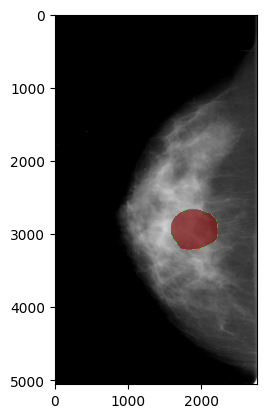

In [74]:
from matplotlib.colors import ListedColormap

all_images = list(images_folder.glob('*.png'))

corresponding_mask = lambda X: masks_folder / f'{X.name}'


for image in all_images[1:]:
    mask = corresponding_mask(image)
    if not mask.exists():
        print(f'Missing mask for {image}')
        break
    
    image = np.array(Image.open(image))
    mask = np.array(Image.open(mask))
    
    
    
    fig, ax = plt.subplots(1,1)
    
    colors = [(0, 0, 0, 0),    # Transparent for label 0
        (0, 1, 0, 0.6),  # Bright green with alpha
        (0, 0.5, 0, 0.6),# Dark green with alpha
        (1, 0, 0, 0.6),  # Bright red with alpha
        (0.5, 0, 0, 0.6)]# Dark red with alpha
    cmap = ListedColormap(colors)
    
    ax.imshow(np.array(image)/66000, cmap='gray')

    ax.imshow(mask, cmap=cmap)
    
    plt.show()
    
    break